In [100]:
!nvidia-smi

Thu Jun 22 11:09:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.105.01   Driver Version: 515.105.01   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100S-PCI...  On   | 00000000:25:00.0 Off |                    0 |
| N/A   58C    P0   189W / 250W |  28568MiB / 32768MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100S-PCI...  On   | 00000000:81:00.0 Off |                    0 |
| N/A   

In [30]:
import argparse
import torch
import torch.nn as nn
from torchvision import transforms as T
from src.dataset.vanilla_lpcvc import LPCVCDataset
import torchvision

from src.model.model import UNET

from tqdm import tqdm
import random
import numpy as np
import cv2
import PIL

import matplotlib.pyplot as plt
import albumentations as A

IMG_WIDTH = 256
IMG_HEIGHT = 256

In [79]:
model = UNET(in_channels=3, out_channels=14, features=[64, 128, 256, 512]).to('cuda:1')

In [46]:
t_train = T.Compose([T.ToPILImage(), T.Resize(128,PIL.Image.NEAREST)])


aug = A.Compose([
            #A.ToPILImage(),
            A.Resize(width=IMG_WIDTH, height=IMG_HEIGHT, interpolation=cv2.INTER_NEAREST),
            A.OneOf([
                A.RandomSizedCrop(min_max_height=(IMG_HEIGHT-30, IMG_HEIGHT), height=IMG_HEIGHT, width=IMG_WIDTH, p=0.5),
                A.PadIfNeeded(min_height=IMG_HEIGHT, min_width=IMG_WIDTH, p=0.5)
            ], p=1),    
            A.VerticalFlip(p=0.5),              
            A.RandomRotate90(p=0.5),
            A.OneOf([
                A.ElasticTransform(alpha=12, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
                A.GridDistortion(p=0.5),
                A.OpticalDistortion(distort_limit=0.1, shift_limit=0.5, p=1)                  
                ], p=0.8),
            A.CLAHE(p=0.8),
            A.RandomBrightnessContrast(p=0.8),    
            A.RandomGamma(p=0.8)
])

train_dataset = LPCVCDataset(datapath='/home/infres/nvernier-22/project/LPCVC-2023/dataset/',transform=aug, n_class=14, train=True)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


/home/infres/nvernier-22/anaconda3/envs/lpcvc/lib/python3.6/site-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


(256, 256)


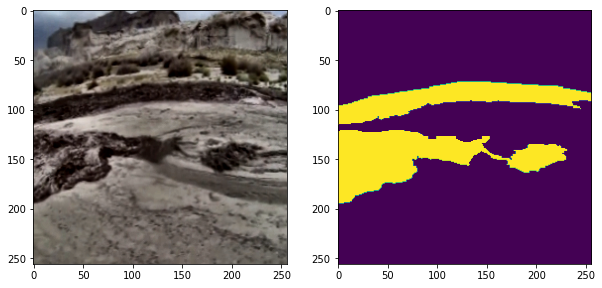

In [77]:
img, label = train_dataset[0]


labels = label.reshape(1, 14, IMG_WIDTH, IMG_HEIGHT)
labels = torch.tensor(labels).to('cuda:1')
labels = labels.reshape((1, 14,  IMG_WIDTH, IMG_HEIGHT))

labels = labels.cpu().data.max(1)[1].numpy()
labels.astype(np.uint8)
labels = np.squeeze(labels, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Affichage de la première image
axes[0].imshow(np.transpose(img, (1, 2, 0)))

# Affichage de la deuxième image
axes[1].imshow(labels)

print(labels.shape)


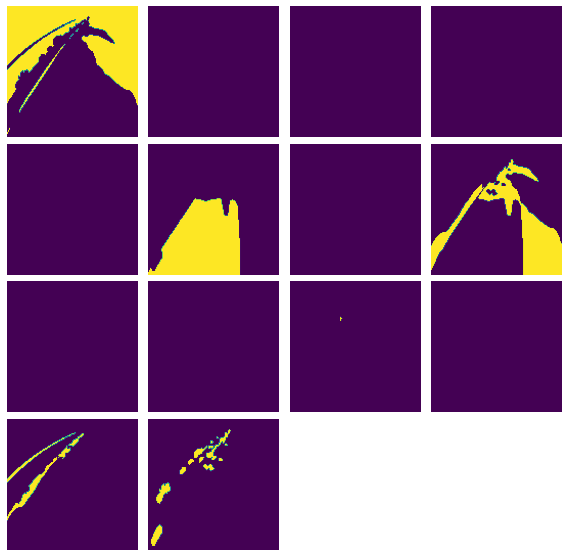

In [8]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

# Parcours des images et tracé dans chaque sous-graphique
for i, ax in enumerate(axes.flatten()):
    if i < len(label):
        img = label[i]
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')

# Réglage des marges entre les sous-graphiques
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Affichage du graphique
plt.show()

In [9]:
LEARNING_RATE = 1e-4


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [10]:
def train(model, criterion, optimizer, scaler, train_loader):
    model.train()
    running_loss=0
    loop = tqdm(train_loader)
    
    for batch_idx, (data, targets) in enumerate(loop):
        
        data = data.to(device='cuda:1')
        targets = targets.to(device='cuda:1')        
            
        with torch.cuda.amp.autocast():
            outputs=model(data)
            if(batch_idx == 0):
                output_n = outputs.detach().cpu().numpy()
                target_n = targets.detach().cpu().numpy()
                data_n = data[0].detach().cpu().numpy()

                # output_n = np.argmax(output_n[0], axis=0)
                # output_n[output_n != 0] = -1
                # output_n[output_n == 0] = 1
            
                output_n = np.argmax(output_n[0], axis=0)
                target_n = np.argmax(target_n[0], axis=0)

                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/input'+str(0)+'.png', data_n[0])
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(0)+'.png', output_n)
                plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(0)+'.png', target_n)
            loss = criterion(outputs, targets)
            
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())
            
        running_loss += loss.item()

    train_loss=running_loss/len(train_loader)
        
    print('Train Loss: %.3f'%(train_loss))
    return(train_loss)

In [11]:

def draw(i):
    data, target = train_dataset[0]
    data = torch.tensor(data.reshape((1, 3, 128, 128))).to('cuda:1')
    target = torch.tensor(target.reshape((1, 14, 128, 128))).to('cuda:1')
                   
    output=model(data)

    _, predicted = output.max(1)

    print(predicted.shape)

    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()

    output = np.argmax(output[0], axis=0)
    plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/predict'+str(i)+'.png', output[ :, :])
    if(i==1):
        plt.imsave('/home/infres/nvernier-22/project/LPCVC-2023/src/model/target'+str(i)+'.png', target[0, 0, :, :])

In [12]:
for epoch in range(1, 100):
    print('\nEpoch : %d'%epoch)
    train(model, criterion=criterion, optimizer=optimizer, scaler=scaler, train_loader=train_loader)
    draw(epoch)



Epoch : 1


100%|██████████| 64/64 [00:05<00:00, 12.12it/s, loss=2.48]
/home/infres/nvernier-22/anaconda3/envs/lpcvc/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


Train Loss: 2.541
torch.Size([1, 128, 128])

Epoch : 2


 61%|██████    | 39/64 [00:02<00:01, 14.39it/s, loss=2.4] 


KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(), 'src/model/vanilla-lpcvc_'+str(100)+'.pth')

In [99]:
model.load_state_dict(torch.load("/home/infres/nvernier-22/project/LPCVC-2023/src/model/vanilla-lpcvc_unet_300_32.pth"))

<All keys matched successfully>

In [94]:
transform = A.Compose([A.Resize(width=128, height=128, interpolation=cv2.INTER_NEAREST)])
test_dataset = LPCVCDataset(datapath='/home/infres/nvernier-22/project/LPCVC-2023/dataset/',transform=transform, n_class=14, train=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


  8%|▊         | 5/64 [00:01<00:12,  4.74it/s]


In [ ]:
!nvidia-smi

Tue Jun 20 19:00:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   27C    P0    36W / 250W |  16034MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:AF:00.0 Off |                    0 |
| N/A   

In [36]:
len(test_dataset)

100

100%|██████████| 64/64 [00:17<00:00,  3.68it/s]


0.003074578712216037


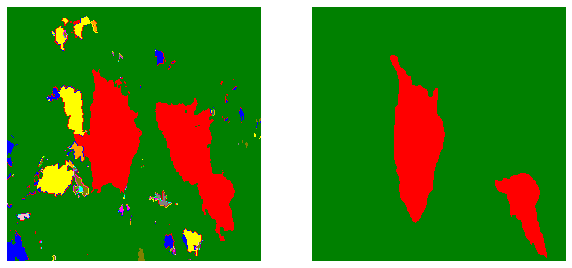

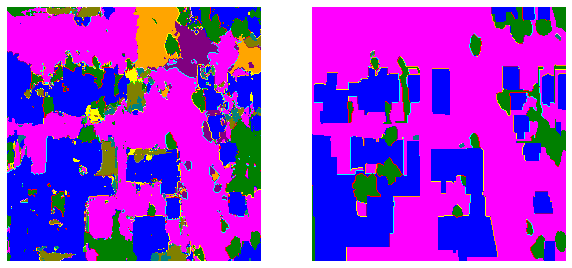

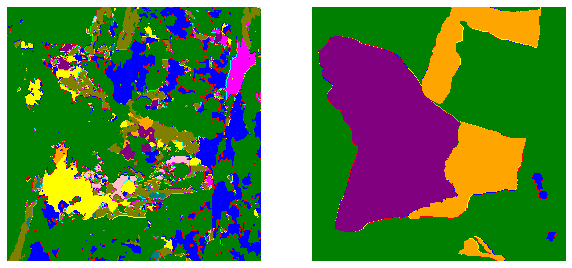

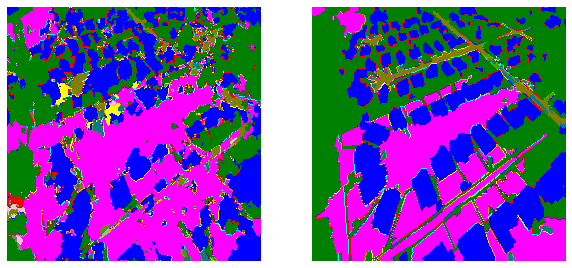

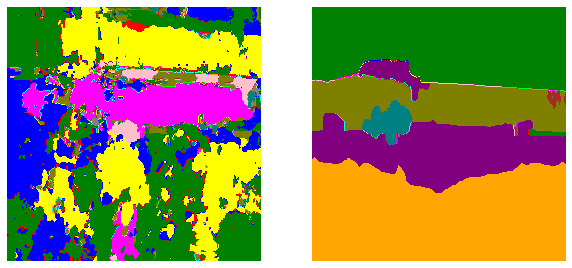

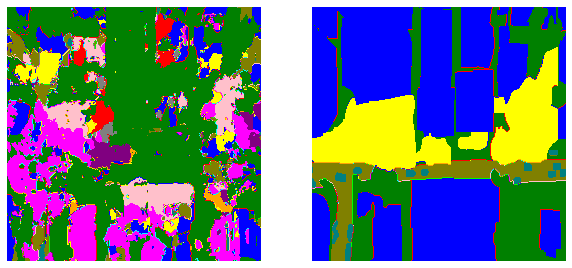

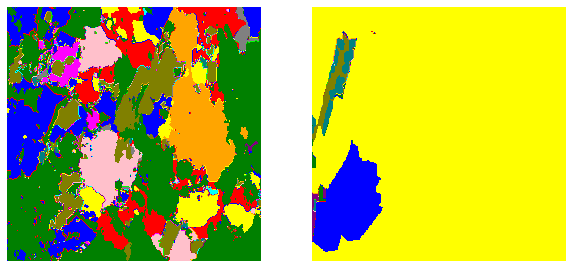

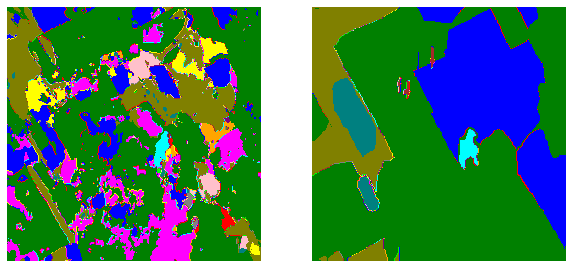

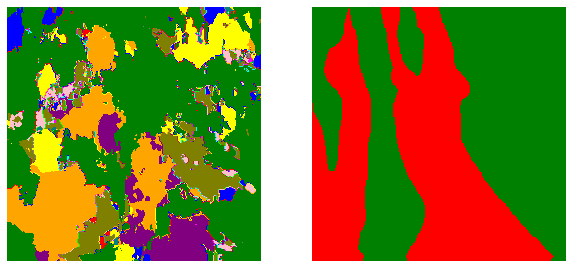

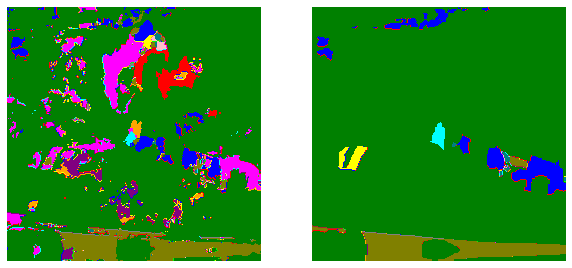

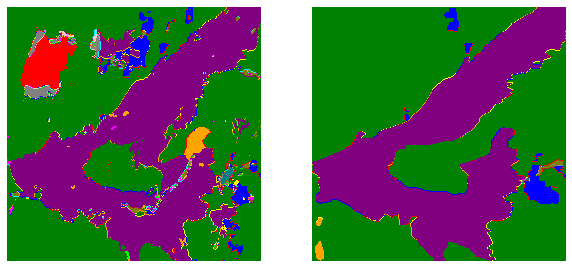

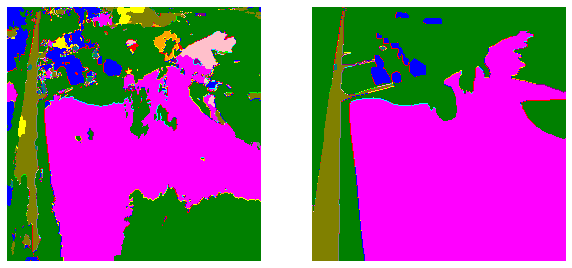

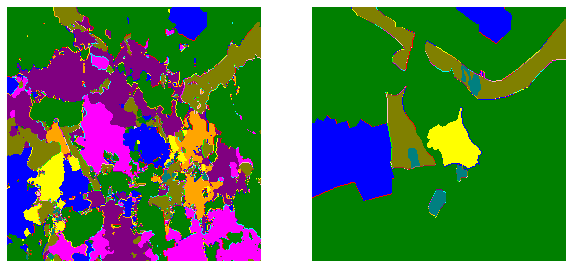

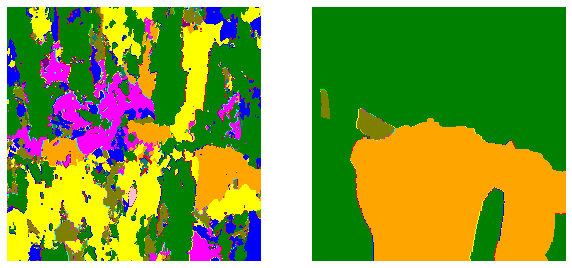

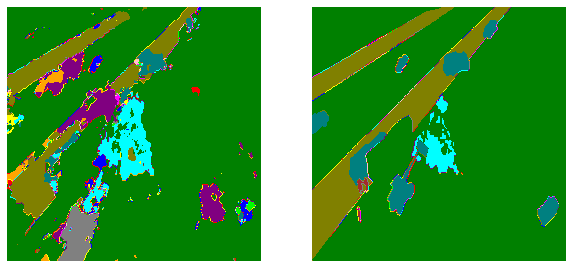

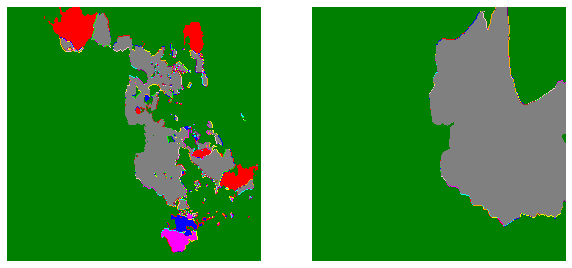

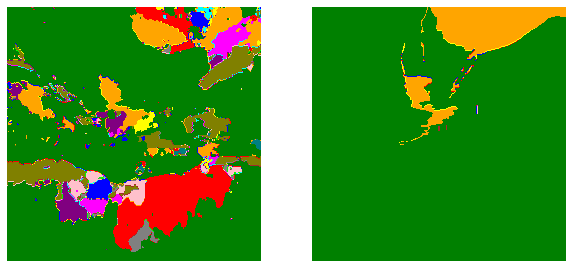

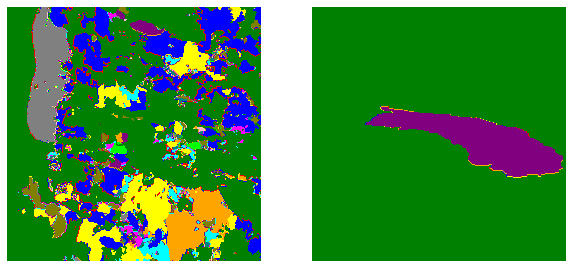

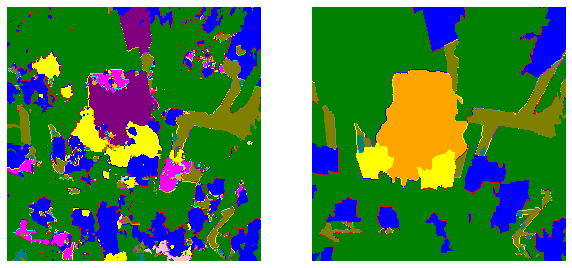

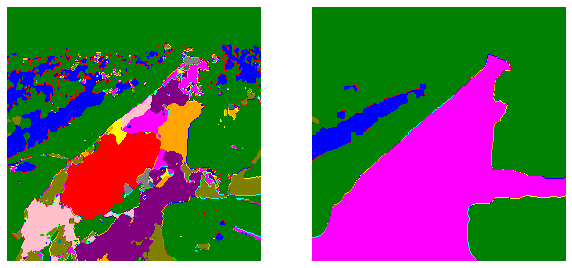

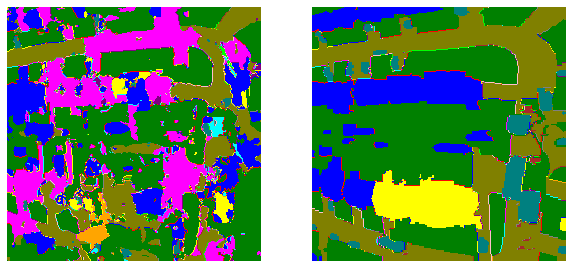

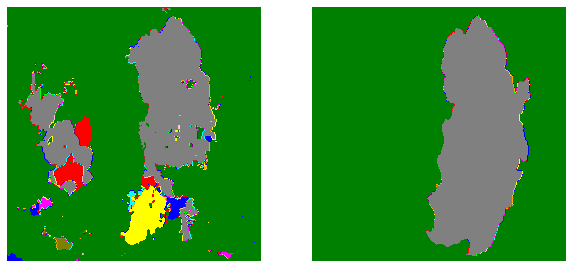

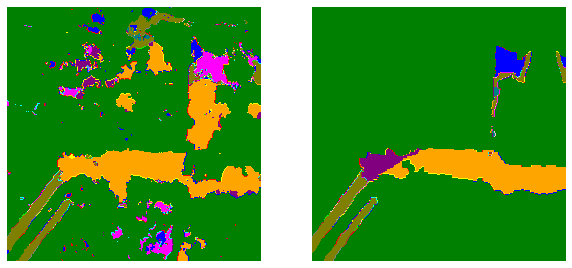

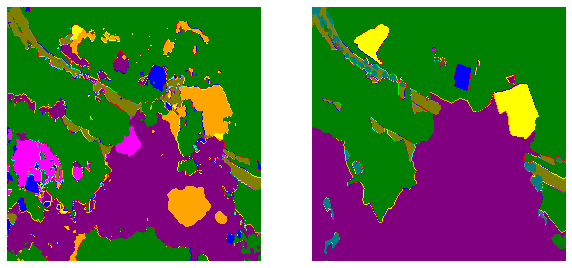

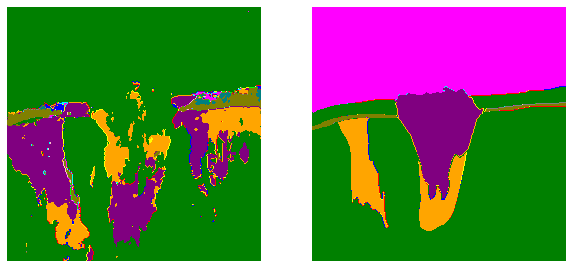

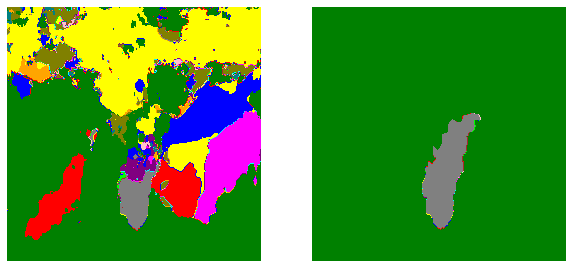

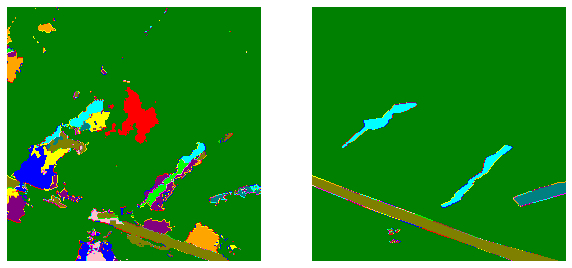

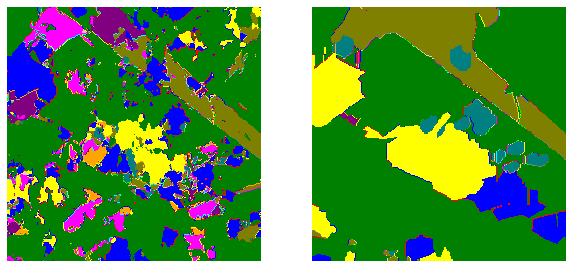

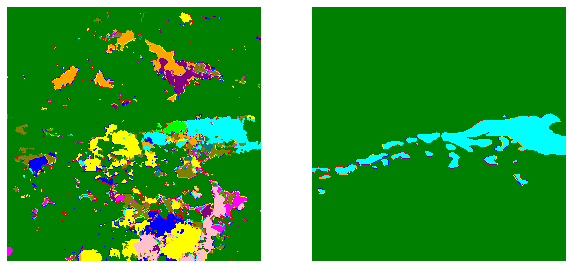

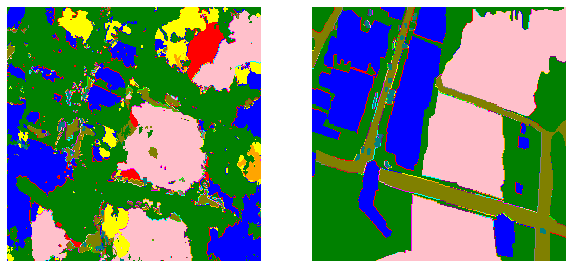

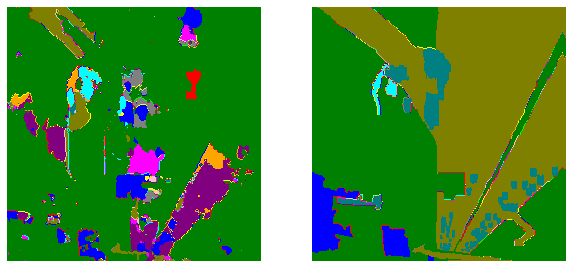

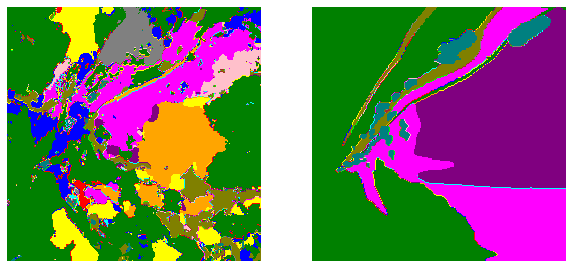

In [97]:
from sample_solution.evaluation.accuracy import AccuracyTracker
from matplotlib.colors import ListedColormap

loop = tqdm(train_loader)

accuracyTracker: AccuracyTracker = AccuracyTracker(n_classes=14)
tot_m_dice = 0
tot = 0
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(loop):
        tot += 1
        data = data.to(device='cuda:1')
        targets = targets.to(device='cuda:1')     

        preds = model(data)

        preds = preds.cpu().data.max(1)[1].numpy()
        targets = targets.cpu().data.max(1)[1].numpy()
        preds.astype(np.uint8)
        targets.astype(np.uint8)

        if(batch_idx%2==0):
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            colors = ['green', 'red', 'blue', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'pink', 'lime', 'brown', 'gray', 'olive', 'teal', 'navy']
            cmap = ListedColormap(colors[:14])
            # Tracé de la première image
            axes[0].imshow(preds[0], cmap=cmap, vmin=0, vmax=13)
            axes[0].axis('off')

            # Tracé de la deuxième image
            axes[1].imshow(targets[0], cmap=cmap, vmin=0, vmax=13)
            axes[1].axis('off')

    accuracyTracker.update(targets, preds)
    tot_m_dice += accuracyTracker.get_mean_dice()

print(tot_m_dice/tot)